Pré-processamento realizado em Processing.ipynb

# Bibliotecas

In [131]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import heapq
import matplotlib.pyplot as plt
import ml_time_series as mls
import timeit
from scipy import signal
from datetime import datetime
from sys import platform
from itertools import cycle
from scipy import interp
from sklearn import preprocessing
from sklearn import utils
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

%matplotlib notebook

---

# Funções

### Stack Horizontal das features

In [2]:
def Stacker(files_,t):
    
    #Lê dados do arquivo e remove janela
    Xc = np.load('preproc/'+files_[len(files_)-1])
    Xc = Xc[:-49]

    #Aplica Hstack nos dados
    for j in range(0,len(files_)-1):
        Xci = np.load('preproc/'+files_[j])
        Xc = np.hstack((Xc.reshape(Xc.shape),Xci.reshape(Xci.shape)))
        
    if "v" in t:
        np.save('preproc/stacked_v/'+t+'_hs', Xc, allow_pickle=False)
        DATAv_hs.append(t+'_hs.npy')
    else:
        np.save('preproc/stacked_t/'+t+'hs', Xc, allow_pickle=False)
        DATA_hs.append(t+'hs.npy')

### Função ProccessData(): Aplica PCA, rotula e salva a amostra 

In [3]:
def ProccessData(x,DATA,LABEL):
    
    if "v" in x:
         Xc = np.load("preproc/stacked_v/"+x)
    else:
         Xc = np.load("preproc/stacked_t/"+x)
   
    print '\nXc initial shape ', Xc.shape
    
    #Principal component analysis
    pca = PCA(n_components=8)
    pca.fit(Xc)
    Xc = pca.transform(Xc)
    print pca.explained_variance_ratio_
    entropy.append(sum(pca.explained_variance_ratio_))
    print 'Xc PCA shape ', Xc.shape
    
    #Labeling the PKS level    
    C = (np.ones(len(Xc))*LABEL).reshape((len(Xc),1))
    Xc = np.hstack((Xc.reshape(Xc.shape),C.reshape((len(Xc),1)))) 
    print 'Xc labeled shape ', Xc.shape
    
    # Salving in file on the folder </preproc/labeled>
    if "v" in x:
        np.save('./preproc/labeled_v/'+x[:9]+'_tsl', Xc, allow_pickle=False)
        print '\n'+x[:9]+'_tsl'
        DATAv.append(x[:9]+'_tsl.npy')
    else:
        np.save('./preproc/labeled_t/'+x[:8]+'_tsl', Xc, allow_pickle=False)
        print '\n'+x[:8]+'_tsl'
        DATA.append(x[:8]+'_tsl.npy')

In [114]:
print ("A  Prote{\c{c}}{\~{a}}o Radiol{\'{o}}gica")

A  Prote{\c{c}}{\~{a}}o Radiol{'{o}}gica


### Calcula e plota a curva ROC e AUC

In [145]:
def ROCCurve(y_pred, y_real, clf):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for k in range(1,5,1):

        yy_pred = np.array([0 if int(el)!=k else 1 for el in y_pred])
        yy_valid = np.array([0 if int(el)!=k else 1 for el in y_real])

        fpr[k], tpr[k], _ = roc_curve(yy_pred, yy_valid)
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(yy_pred.ravel(), yy_valid.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    n_classes = len(np.unique(y_validate))
    lw = 2
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,5,1)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(1,5,1):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves

    def plot_roc_c():
        params = {'text.usetex': True,'text.latex.unicode': True}
        plt.rcParams.update(params)
        plt.plot(fpr["micro"], tpr["micro"],
                 label=u'micro-média da curva ROC (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='m', linestyle=':', linewidth=6)

        plt.plot(fpr["macro"], tpr["macro"],
                 label=u'macro-média da curva ROC (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=6)

        colors = cycle(['aqua', 'firebrick', 'darkorange', 'chartreuse'])

        for i, color in zip(range(1,5,1), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=u'curva ROC da classe N-{0} (área = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel(u'Taxa de Falsos Positivos')
        plt.ylabel(u'Taxa de Verdadeiros Positivos')
        #plt.title('Some extension of Receiver operating characteristic to multi-class')
        #plt.title(clf)
        plt.legend(loc="lower right")

    fig = plt.figure()
    plot_roc_c()
    fig.set_size_inches(w=7,h=6)
    fig_name = 'CF_figs/ROC_'+clf+'.png'
    fig.savefig(fig_name)
    plt.show()    

### Calcula matriz de confusão e métricas

In [177]:
def Metrics(y_pred, y_real, clf):
    
    class_names = np.array(['N-1', 'N-2', 'N-3', 'N-4'])

    yvalid = y_real 
    
    from sklearn.metrics import confusion_matrix
    
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion de matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        params = {'text.usetex': True,'text.latex.unicode': True}
        plt.rcParams.update(params)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        #plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)


        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Matriz de confusão normalizada")
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, ('%.3f' % cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        else:
            print('Matriz de confusão, sem normalização')
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        print(cm)

        plt.tight_layout()
        plt.ylabel('Valores reais')
        plt.xlabel('Valores preditos')

    # Compute confusion matrix
    cm = confusion_matrix(yvalid, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    fig = plt.figure()
    plot_confusion_matrix(cm, classes=class_names)#, title=u'Matriz de confusão -'+clf)
    fig.set_size_inches(w=7,h=6)

    # Plot normalized confusion matrix
    fig = plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True)#,
                          #title=u'Matriz de confusão - '+clf)
    fig_name = 'CF_figs/cm_'+clf+'.png'
    fig.set_size_inches(w=7,h=6)
    fig.savefig(fig_name)

    plt.show()

    confusion_matrix = cm.astype('float')
    FN = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FP = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print ''
    print 'Métricas:'
    print ('Sensibilidade por classe:')
    print TPR*100
    print ('Sensibilidade média %.2f%%' %(sum(TPR)/4*100))
    print ''
    
    print ('Especificidade por classe:')
    print TNR*100
    print ('Especificidade média%.2f%%' %(sum(TNR)/4*100))
    print ''
    
    print ('Precisão por classe:')
    print PPV*100
    print ('Precisão média%.2f%%' %(sum(PPV)/4*100))
    print ''
    
    print ('Acurácia por classe:')
    print ACC*100
    print ('Acurácia média%.2f%%' %(sum(ACC)/4*100))
    
    target_names = ['N-1', 'N-2', 'N-3', 'N-4']
    print ''
    print 'Relatório:'
    print(classification_report(y_real, y_pred, target_names=target_names))

---

# Processamento dos dados

### Cria array com nome dos arquivos de amostra

In [6]:
if platform == "linux" or platform == "linux2":
    files = os.listdir('db/partitioned')
elif platform == "win32":
    files = os.listdir('C:\Users\jorge.junior\Documents\GitHub\PKS_ML\db\partitioned')
    
files_ = []
for i in files:
    files_.append([i[:-4]+'_filt.npy',i[:-4]+'_rms.npy',i[:-4]+'_fft.npy',i[:-4]+'_std.npy'])
    
list.sort(files)

### Cria array com conjunto de  total (treinamento e teste) e conjunto de validação

In [7]:
DATA_hs = []
DATAv_hs = []
for i in range(len(files_)):
    Stacker(files_[i],files_[i][0][:9])

### Ordena os arrays DATA_hs e DATAv_hs de forma crescente

In [8]:
list.sort(DATA_hs)
list.sort(DATAv_hs)
DATA_hs, DATAv_hs

(['pi03.1.1_hs.npy',
  'pi03.1.2_hs.npy',
  'pi03.1.3_hs.npy',
  'pi03.2.1_hs.npy',
  'pi03.2.2_hs.npy',
  'pi03.2.3_hs.npy',
  'pi06.1.1_hs.npy',
  'pi06.1.2_hs.npy',
  'pi06.1.3_hs.npy',
  'pi06.3.1_hs.npy',
  'pi06.3.2_hs.npy',
  'pi06.3.3_hs.npy',
  'pi07.1.1_hs.npy',
  'pi07.1.2_hs.npy',
  'pi07.1.3_hs.npy',
  'pi07.2.1_hs.npy',
  'pi07.2.2_hs.npy',
  'pi07.2.3_hs.npy',
  'pi09.1.1_hs.npy',
  'pi09.1.2_hs.npy',
  'pi09.1.3_hs.npy',
  'pi09.3.1_hs.npy',
  'pi09.3.2_hs.npy',
  'pi09.3.3_hs.npy',
  'pi16.1.1_hs.npy',
  'pi16.1.2_hs.npy',
  'pi16.1.3_hs.npy',
  'pi16.2.1_hs.npy',
  'pi16.2.2_hs.npy',
  'pi16.2.3_hs.npy',
  'pi17.1.1_hs.npy',
  'pi17.1.2_hs.npy',
  'pi17.1.3_hs.npy',
  'pi17.2.1_hs.npy',
  'pi17.2.2_hs.npy',
  'pi17.2.3_hs.npy',
  'pr03.1.1_hs.npy',
  'pr03.1.2_hs.npy',
  'pr03.1.3_hs.npy',
  'pr03.2.1_hs.npy',
  'pr03.2.2_hs.npy',
  'pr03.2.3_hs.npy',
  'pr06.1.1_hs.npy',
  'pr06.1.2_hs.npy',
  'pr06.1.3_hs.npy',
  'pr06.2.1_hs.npy',
  'pr06.2.2_hs.npy',
  'pr06.2.3_h

### Mostra a forma da amostra para simples conferência

In [9]:
Xc = np.load('preproc/stacked_t/pr06.1.1_hs.npy')
dfn = pd.DataFrame(data=Xc)
dfn.head()
Xc.shape

(3284L, 16L)

### Aplica função ProccessData() no conjunto de treinamento/teste

In [10]:
entropy = []
start = timeit.default_timer()
l=[2,2,2,2,2,2, 3,3,3,3,3,3, 4,4,4,4,4,4, 1,1,1,1,1,1, 1,1,1,1,1,1, 2,2,2,2,2,2, 3,3,3, 4,4,4,4,4,4, 1,1,1,1,1,1, 1,1,1,1,1,1]
DATA = []

for x, y in zip(DATA_hs, l):
    ProccessData(x,DATA,y)
    
stop = timeit.default_timer()
ti = stop - start 
print ('Tempo total para o envelopamento: %.2f min' % (ti/60))


Xc initial shape  (2617L, 16L)
[0.35072063 0.21266328 0.13717139 0.11774686 0.08812051 0.07411215
 0.01183915 0.00722656]
Xc PCA shape  (2617L, 8L)
Xc labeled shape  (2617L, 9L)

pi03.1.1_tsl

Xc initial shape  (2617L, 16L)
[0.30583208 0.23724818 0.14367376 0.12896779 0.08794486 0.07767164
 0.01069367 0.00759266]
Xc PCA shape  (2617L, 8L)
Xc labeled shape  (2617L, 9L)

pi03.1.2_tsl

Xc initial shape  (2617L, 16L)
[0.29823729 0.22265284 0.15932559 0.11325486 0.09879587 0.08733394
 0.01180565 0.00818418]
Xc PCA shape  (2617L, 8L)
Xc labeled shape  (2617L, 9L)

pi03.1.3_tsl

Xc initial shape  (3284L, 16L)
[0.7082743  0.09308488 0.07371052 0.05915716 0.03238076 0.02710294
 0.00360552 0.00251622]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pi03.2.1_tsl

Xc initial shape  (3284L, 16L)
[0.28755375 0.25509324 0.18025701 0.10663444 0.08907037 0.06350168
 0.01110434 0.00647238]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pi03.2.2_tsl

Xc initial shape  (3284L, 16L)
[9.

[0.8142253  0.11293106 0.04144711 0.01022096 0.00773919 0.00709233
 0.00384469 0.00247169]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pr06.1.3_tsl

Xc initial shape  (3284L, 16L)
[0.52356215 0.34462335 0.05120205 0.02978489 0.01941722 0.01330159
 0.01062001 0.00741015]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pr06.2.1_tsl

Xc initial shape  (3284L, 16L)
[0.81302918 0.13223814 0.0241259  0.01089009 0.00798945 0.00512136
 0.0035101  0.00307119]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pr06.2.2_tsl

Xc initial shape  (3284L, 16L)
[0.52307436 0.35794213 0.03761049 0.03120154 0.01544234 0.01421056
 0.01217354 0.00825977]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pr06.2.3_tsl

Xc initial shape  (3284L, 16L)
[0.6133578  0.17136321 0.11696256 0.0844594  0.00579827 0.00479649
 0.00180596 0.00133174]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

pr07.1.1_tsl

Xc initial shape  (3284L, 16L)
[0.56747781 0.1934371  0.14159278 0

### Retorna o valor das 10 menores entropias do conjunto de treinamento/teste

In [11]:
elements = heapq.nsmallest(10, entropy)
elements

[0.9995902290975087,
 0.9996005225428527,
 0.9996246434243088,
 0.9996872006082552,
 0.9997627580062369,
 0.9997702560760484,
 0.9997910851833363,
 0.9998250298749422,
 0.9998322949178883,
 0.9998330148999053]

### Aplica função ProccessData() no conjunto de validação

In [12]:
entropy = []
start = timeit.default_timer()
l=[2,2,2, 3,3,3, 4,4,4, 1,1,1, 1,1,1, 2,2,2, 3,3,3, 4,4,4, 1,1,1, 1,1,1]
DATAv = []

for x, y in zip(DATAv_hs, l):
    ProccessData(x,DATAv,y)
    
stop = timeit.default_timer()
ti = stop - start 
print ('Tempo total para o envelopamento: %.2f min' % (ti/60))


Xc initial shape  (2617L, 16L)
[0.78558194 0.07845209 0.04922876 0.03450836 0.02552611 0.0167179
 0.00869551 0.00121047]
Xc PCA shape  (2617L, 8L)
Xc labeled shape  (2617L, 9L)

piv03.3.1_tsl

Xc initial shape  (2617L, 16L)
[0.26644137 0.23782622 0.19782561 0.12044037 0.09153767 0.07113588
 0.00880998 0.0056653 ]
Xc PCA shape  (2617L, 8L)
Xc labeled shape  (2617L, 9L)

piv03.3.2_tsl

Xc initial shape  (2617L, 16L)
[7.37214211e-01 1.82198736e-01 3.62878610e-02 1.99955181e-02
 1.54430660e-02 7.26022548e-03 9.02609038e-04 6.56810019e-04]
Xc PCA shape  (2617L, 8L)
Xc labeled shape  (2617L, 9L)

piv03.3.3_tsl

Xc initial shape  (3284L, 16L)
[8.35786904e-01 6.27174848e-02 4.72157164e-02 4.22243098e-02
 5.89274383e-03 4.04723871e-03 1.58706191e-03 4.78048721e-04]
Xc PCA shape  (3284L, 8L)
Xc labeled shape  (3284L, 9L)

piv06.2.1_tsl

Xc initial shape  (3284L, 16L)
[7.85562590e-01 8.67559946e-02 6.72729947e-02 4.21188333e-02
 1.09865832e-02 4.77584132e-03 1.69601189e-03 7.62584513e-04]
Xc PCA

### Retorna o valor das 10 menores entropias do conjunto de validação

In [13]:
elements = heapq.nsmallest(10, entropy)
elements

[0.9996823983987692,
 0.9997655614648464,
 0.999769992835312,
 0.999804611022411,
 0.9998435498100618,
 0.9998632858700325,
 0.9998799708737495,
 0.9998800580449382,
 0.9998988153440445,
 0.999908254579974]

### Vertical Stack dos dados e separa os dados como matriz X e rótulos como vetor y do conjuto de treinamento/teste

In [33]:
cdata=0
#Separando set de dados X, e set de labels y - Treino e Teste
Xc = np.load("preproc/labeled_t/"+DATA[0])

for i in DATA[1:]:
    Xc = np.vstack((Xc,np.load('preproc/labeled_t/'+i)))
    cdata += 1
    print ("Vstacking DATA test on X: %i de %i" % (cdata, len(DATA)))
    
X = Xc[:,0:(Xc.shape[1]-1)]

print "Creating labels vector ..."

yz = Xc[:,[(Xc.shape[1]-1)]]
y = np.array([])
for i in range(len(yz)):
    y = np.hstack((y,yz[i]))
    
X.shape, y.shape

Vstacking DATA test on X: 1 de 57
Vstacking DATA test on X: 2 de 57
Vstacking DATA test on X: 3 de 57
Vstacking DATA test on X: 4 de 57
Vstacking DATA test on X: 5 de 57
Vstacking DATA test on X: 6 de 57
Vstacking DATA test on X: 7 de 57
Vstacking DATA test on X: 8 de 57
Vstacking DATA test on X: 9 de 57
Vstacking DATA test on X: 10 de 57
Vstacking DATA test on X: 11 de 57
Vstacking DATA test on X: 12 de 57
Vstacking DATA test on X: 13 de 57
Vstacking DATA test on X: 14 de 57
Vstacking DATA test on X: 15 de 57
Vstacking DATA test on X: 16 de 57
Vstacking DATA test on X: 17 de 57
Vstacking DATA test on X: 18 de 57
Vstacking DATA test on X: 19 de 57
Vstacking DATA test on X: 20 de 57
Vstacking DATA test on X: 21 de 57
Vstacking DATA test on X: 22 de 57
Vstacking DATA test on X: 23 de 57
Vstacking DATA test on X: 24 de 57
Vstacking DATA test on X: 25 de 57
Vstacking DATA test on X: 26 de 57
Vstacking DATA test on X: 27 de 57
Vstacking DATA test on X: 28 de 57
Vstacking DATA test on X: 29 

((176484L, 8L), (176484L,))

### Retorna a quantidade de classes

In [34]:
np.unique(y)

array([1., 2., 3., 4.])

### Divide os dados em sets de treino, test e validação

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Vertical Stack dos dados e separa os dados como matriz X e rótulos como vetor y do conjuto de validação

In [36]:
cdata=0
#Separando set de dados X, e set de labels y - Validação
Xc = np.load("preproc/labeled_v/"+DATAv[0])
for i in DATAv[1:]:
    Xc = np.vstack((Xc,np.load('preproc/labeled_v/'+i))) 
    cdata += 1
    print ("Vstacking DATA test on X: %i de %i" % (cdata, len(DATAv)))
    
X_validate = Xc[:,0:(Xc.shape[1]-1)]

print "Creating labels vector ..."

yz = Xc[:,[(Xc.shape[1]-1)]]
y_validate = np.array([])
for i in range(len(yz)):
    y_validate = np.hstack((y_validate,yz[i]))
    
X_validate.shape, y_validate.shape

Vstacking DATA test on X: 1 de 30
Vstacking DATA test on X: 2 de 30
Vstacking DATA test on X: 3 de 30
Vstacking DATA test on X: 4 de 30
Vstacking DATA test on X: 5 de 30
Vstacking DATA test on X: 6 de 30
Vstacking DATA test on X: 7 de 30
Vstacking DATA test on X: 8 de 30
Vstacking DATA test on X: 9 de 30
Vstacking DATA test on X: 10 de 30
Vstacking DATA test on X: 11 de 30
Vstacking DATA test on X: 12 de 30
Vstacking DATA test on X: 13 de 30
Vstacking DATA test on X: 14 de 30
Vstacking DATA test on X: 15 de 30
Vstacking DATA test on X: 16 de 30
Vstacking DATA test on X: 17 de 30
Vstacking DATA test on X: 18 de 30
Vstacking DATA test on X: 19 de 30
Vstacking DATA test on X: 20 de 30
Vstacking DATA test on X: 21 de 30
Vstacking DATA test on X: 22 de 30
Vstacking DATA test on X: 23 de 30
Vstacking DATA test on X: 24 de 30
Vstacking DATA test on X: 25 de 30
Vstacking DATA test on X: 26 de 30
Vstacking DATA test on X: 27 de 30
Vstacking DATA test on X: 28 de 30
Vstacking DATA test on X: 29 

((94518L, 8L), (94518L,))

### Retorna a quantidade de classes

In [37]:
np.unique(y_validate)

array([1., 2., 3., 4.])

### Aplica normalizador e retorna o Shape de cada um

In [38]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_validate_std = sc.transform(X_validate)

print X_train_std.shape, X_test_std.shape, X_validate_std.shape, y_train.shape, y_test.shape, y_validate.shape

(123538L, 8L) (52946L, 8L) (94518L, 8L) (123538L,) (52946L,) (94518L,)


---

# Classificação

## Random Forest

In [90]:
#Training and test
rfc = RandomForestClassifier(n_estimators=100, criterion="entropy", oob_score=True, n_jobs = 4)
print 'Training time'
%time rfc = rfc.fit(X_train_std, y_train)
print''
print 'Predict time'
%time rfc_y_pred = rfc.predict(X_test_std)
print''
print ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_test, rfc_y_pred)*100))

Training time
Wall time: 1min 22s

Predict time
Wall time: 1.26 s

ClassifyRF accuracy:---------->87.58 %


In [91]:
#Validation
print 'Predict time'
%time rfc_y_pred_v = rfc.predict(X_validate_std)
print''
print ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(rfc_y_pred_v, y_validate)*100))

Predict time
Wall time: 1.55 s

ClassifyRF accuracy:---------->61.55 %


### Calcula e plota a curva ROC e AUC

<IPython.core.display.Javascript object>


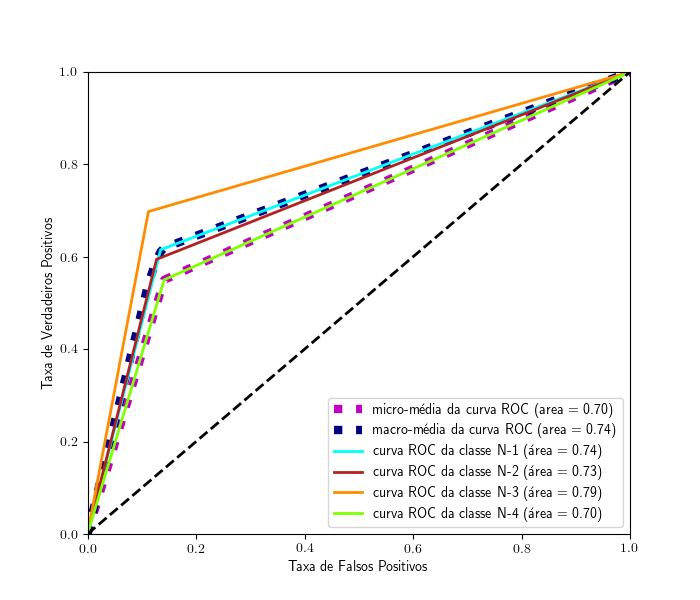

In [179]:
ROCCurve(rfc_y_pred_v, y_validate, 'RF')

### Calcula e plota a martriz de confusão e métricas

<IPython.core.display.Javascript object>


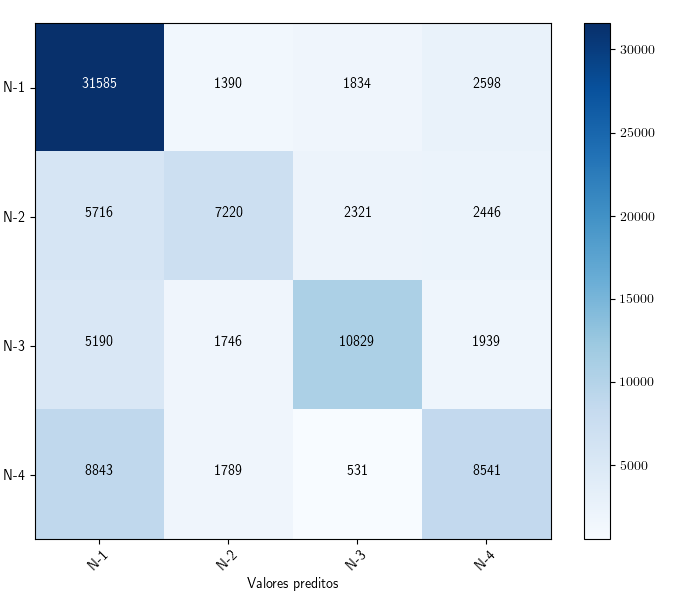

Matriz de confusão, sem normalização
[[31585  1390  1834  2598]
 [ 5716  7220  2321  2446]
 [ 5190  1746 10829  1939]
 [ 8843  1789   531  8541]]


<IPython.core.display.Javascript object>


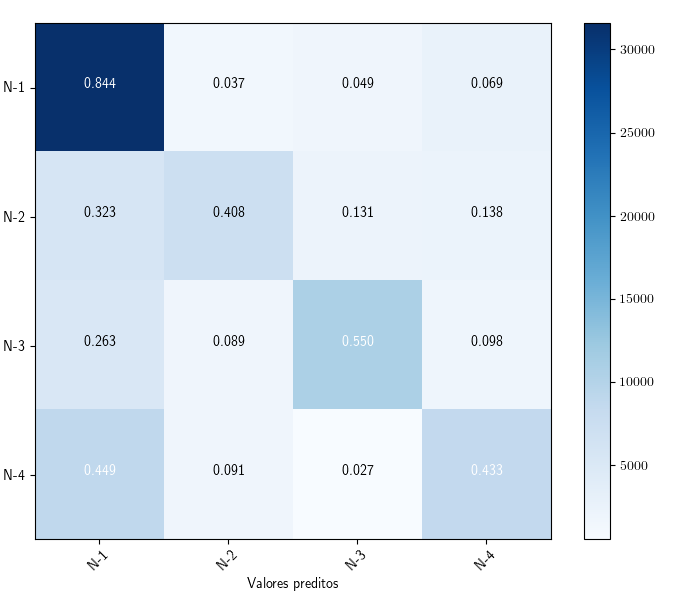

Matriz de confusão normalizada
[[0.84 0.04 0.05 0.07]
 [0.32 0.41 0.13 0.14]
 [0.26 0.09 0.55 0.1 ]
 [0.45 0.09 0.03 0.43]]

Métricas:
Sensibilidade por classe:
[61.53 59.45 69.8  55.02]
Sensibilidade média 61.45%

Especificidade por classe:
[86.52 87.27 88.77 85.87]
Especificidade média87.11%

Precisão por classe:
[84.44 40.78 54.96 43.35]
Precisão média55.88%

Acurácia por classe:
[72.95 83.7  85.65 80.8 ]
Acurácia média80.77%

Relatório:
             precision    recall  f1-score   support

        N-1       0.62      0.84      0.71     37407
        N-2       0.59      0.41      0.48     17703
        N-3       0.70      0.55      0.61     19704
        N-4       0.55      0.43      0.48     19704

avg / total       0.62      0.62      0.60     94518



In [180]:
Metrics(rfc_y_pred_v, y_validate, 'RF')

---

## KNN

In [139]:
#Training and test
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', leaf_size=60, n_jobs=4, p=4)
print 'Training time'
%time knn.fit(X_train_std, y_train)
print''
print 'Predict time'
%time knn_pred = knn.predict(X_test_std)
print ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_test, knn_pred)*100))

Training time
Wall time: 449 ms

Predict time
Wall time: 4min 56s
ClassifyRF accuracy:---------->81.42 %


In [140]:
#Validation
print 'Predict time'
%time knn_pred_v = knn.predict(X_validate_std)
print ''
print ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(knn_pred_v, y_validate)*100))

Predict time
Wall time: 9min 55s

ClassifyRF accuracy:---------->57.38 %


### Calcula e plota a curva ROC e AUC

<IPython.core.display.Javascript object>


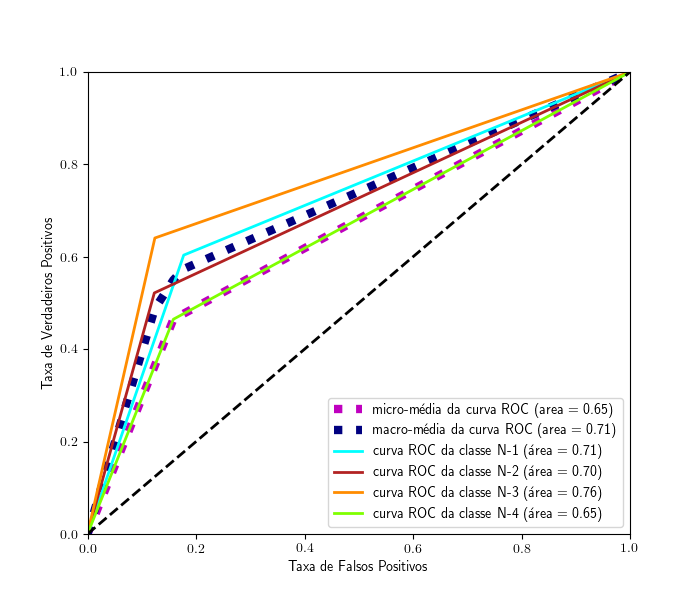

In [181]:
ROCCurve(knn_pred_v, y_validate, 'KNN')

### Calcula e plota a martriz de confusão e métricas

<IPython.core.display.Javascript object>


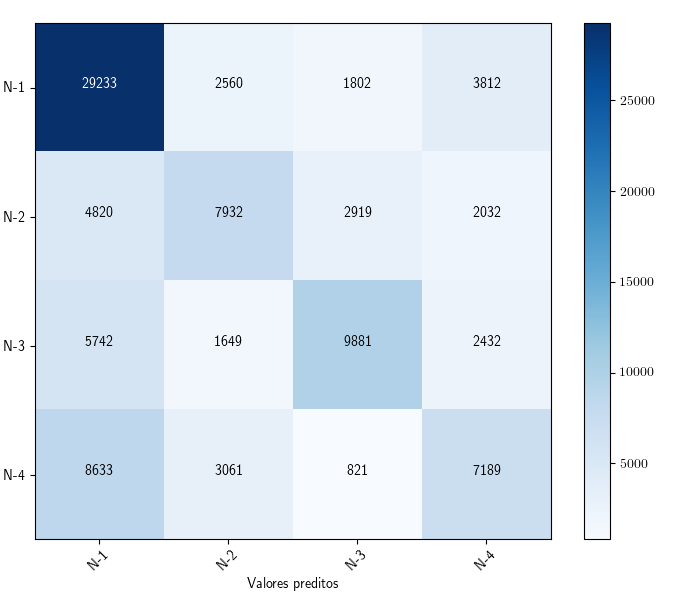

Matriz de confusão, sem normalização
[[29233  2560  1802  3812]
 [ 4820  7932  2919  2032]
 [ 5742  1649  9881  2432]
 [ 8633  3061   821  7189]]


<IPython.core.display.Javascript object>


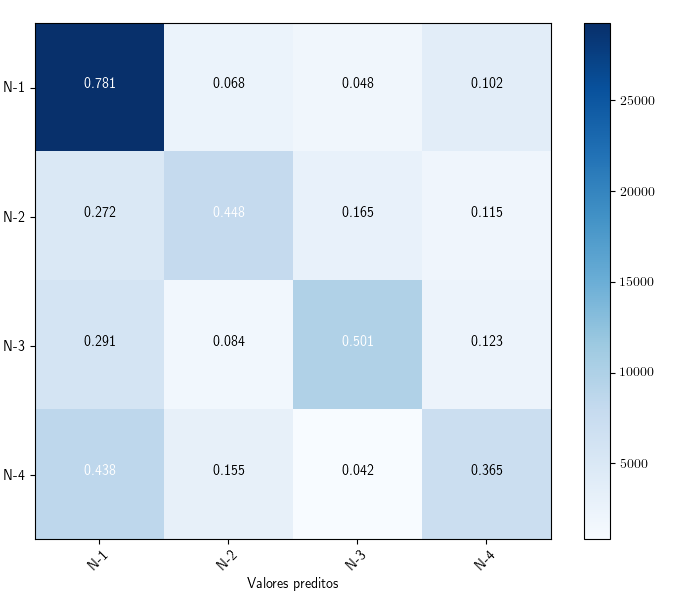

Matriz de confusão normalizada
[[0.78 0.07 0.05 0.1 ]
 [0.27 0.45 0.16 0.11]
 [0.29 0.08 0.5  0.12]
 [0.44 0.16 0.04 0.36]]

Métricas:
Sensibilidade por classe:
[60.36 52.18 64.07 46.49]
Sensibilidade média 55.77%

Especificidade por classe:
[82.27 87.68 87.58 84.17]
Especificidade média85.42%

Precisão por classe:
[78.15 44.81 50.15 36.48]
Precisão média52.40%

Acurácia por classe:
[71.04 81.97 83.74 78.  ]
Acurácia média78.69%

Relatório:
             precision    recall  f1-score   support

        N-1       0.60      0.78      0.68     37407
        N-2       0.52      0.45      0.48     17703
        N-3       0.64      0.50      0.56     19704
        N-4       0.46      0.36      0.41     19704

avg / total       0.57      0.57      0.56     94518



In [182]:
Metrics(knn_pred_v, y_validate, 'KNN')

---

## SVM-RBF

In [143]:
print 'Training time'
%time svm_rbf = svm.SVC(kernel='rbf', gamma=0.2, C=6, decision_function_shape='ovr').fit(X_train_std, y_train)
print ''
print 'Predict time'  
%time rbf_y_pred = svm_rbf.predict(X_test_std)
print ('SVM-RBF accuracy:---------->%.2f %%' % (accuracy_score(y_test, rbf_y_pred)*100))

Training time
Wall time: 41min 22s

Predict time
Wall time: 4min 43s
SVM-RBF accuracy:---------->70.17 %


In [144]:
print 'Predict time'  
%time rbf_y_pred_v = svm_rbf.predict(X_validate_std)
print ('SVM-RBF accuracy:---------->%.2f %%' % (accuracy_score(y_validate, rbf_y_pred_v)*100))

Predict time
Wall time: 7min 57s
SVM-RBF accuracy:---------->54.46 %


### Calcula e plota a curva ROC e AUC

<IPython.core.display.Javascript object>


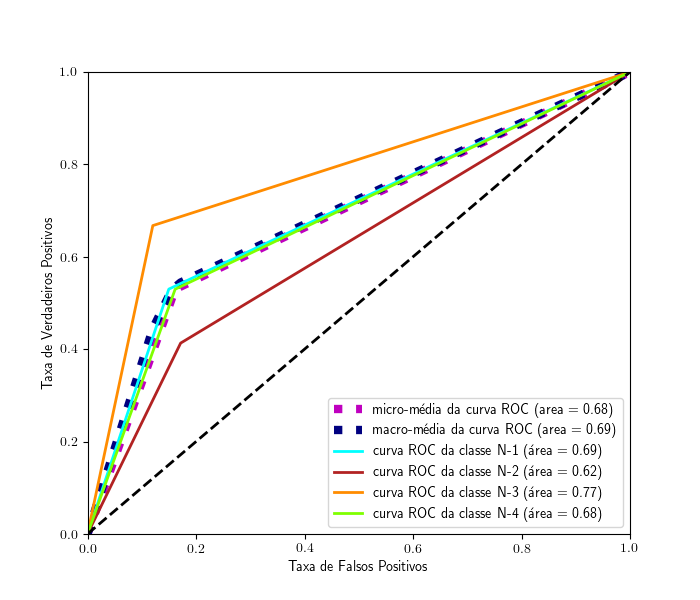

In [148]:
ROCCurve(rbf_y_pred_v, y_validate, 'SVM-RBF')

### Calcula e plota a martriz de confusão e métricas

<IPython.core.display.Javascript object>


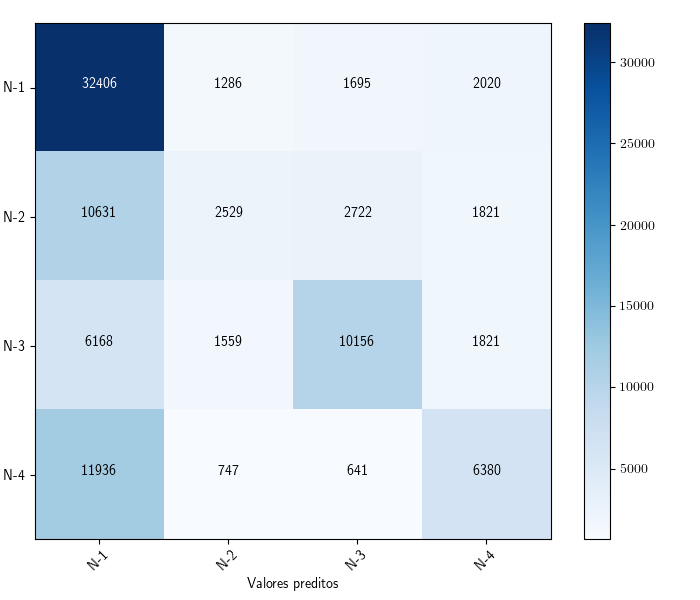

Matriz de confusão, sem normalização
[[32406  1286  1695  2020]
 [10631  2529  2722  1821]
 [ 6168  1559 10156  1821]
 [11936   747   641  6380]]


<IPython.core.display.Javascript object>


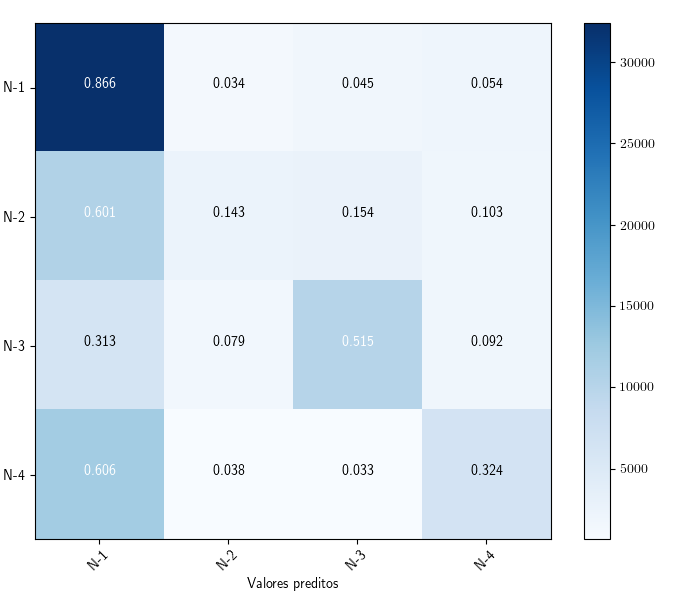

Matriz de confusão normalizada
[[0.87 0.03 0.05 0.05]
 [0.6  0.14 0.15 0.1 ]
 [0.31 0.08 0.52 0.09]
 [0.61 0.04 0.03 0.32]]

Métricas:
Sensibilidade por classe:
[53.   41.32 66.75 52.98]
Sensibilidade média 53.51%

Especificidade por classe:
[85.02 82.83 87.96 83.84]
Especificidade média84.91%

Precisão por classe:
[86.63 14.29 51.54 32.38]
Precisão média46.21%

Acurácia por classe:
[64.31 80.15 84.55 79.91]
Acurácia média77.23%

Relatório:
             precision    recall  f1-score   support

        N-1       0.53      0.87      0.66     37407
        N-2       0.41      0.14      0.21     17703
        N-3       0.67      0.52      0.58     19704
        N-4       0.53      0.32      0.40     19704

avg / total       0.54      0.54      0.51     94518



In [178]:
Metrics(rbf_y_pred_v, y_validate, 'SVM-RBF')

## SVM-Poly

In [ ]:
from sklearn import svm, datasets

print 'Processing time Polynomial'
#%time svm = svm.SVC(kernel='poly', degree=2, coef0=4.7, C=48.9, decision_function_shape='ovr').fit(X_train_std, y_train)
%time svm_poly = svm.SVC(kernel='poly', degree=2,  C=500).fit(X_train_std, y_train)

#poly_y_pred = svm_poly.predict(X_test_std)

print 'Predict time'  
%time poly_y_pred = svm_poly.predict(X_test_std)
from sklearn.metrics import accuracy_score
print ('SVM-Polynomial accuracy:--->%.2f %%' % (accuracy_score(y_test, poly_y_pred)*100))

Processing time Polynomial


In [ ]:
print 'Predict time'  
%time poly_y_pred_v = svm_poly.predict(X_validate_std)
from sklearn.metrics import accuracy_score
print ('SVM-Polynomial accuracy:---------->%.2f %%' % (accuracy_score(y_validate, poly_y_pred_v)*100))

### Calcula e plota a curva ROC e AUC

In [ ]:
ROCCurve(rbf_y_pred_v, y_validate, 'SVM-Poly')

### Calcula e plota a martriz de confusão e métricas

In [ ]:
Metrics(rbf_y_pred_v, y_validate, 'SVM-Poly')

---

## ADABoost

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six.moves import zip

In [ ]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=40),
    n_estimators=15000,
    learning_rate=.75)


print 'Training time'
%time bdt_real.fit(X_train_std, y_train)
print''

Training time


In [89]:
bdt_real

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=40,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.75, n_estimators=15000, random_state=None)

In [88]:
print 'Predict time'
%time bdt_real_y_pred = bdt_real.predict(X_validate_std)
print''
print ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_validate, bdt_real_y_pred)*100))

Predict time
Wall time: 7min 48s

ClassifyRF accuracy:---------->61.17 %


AdaBoostClassifier(DecisionTreeClassifier(max_depth=40),n_estimators=1000,learning_rate=.75)

Wall time: 1h 3min 11s   

ClassifyRF accuracy:---------->61.05 %

---

AdaBoostClassifier(DecisionTreeClassifier(max_depth=40),n_estimators=100,learning_rate=.90)

ClassifyRF accuracy:---------->60.44 %

<IPython.core.display.Javascript object>


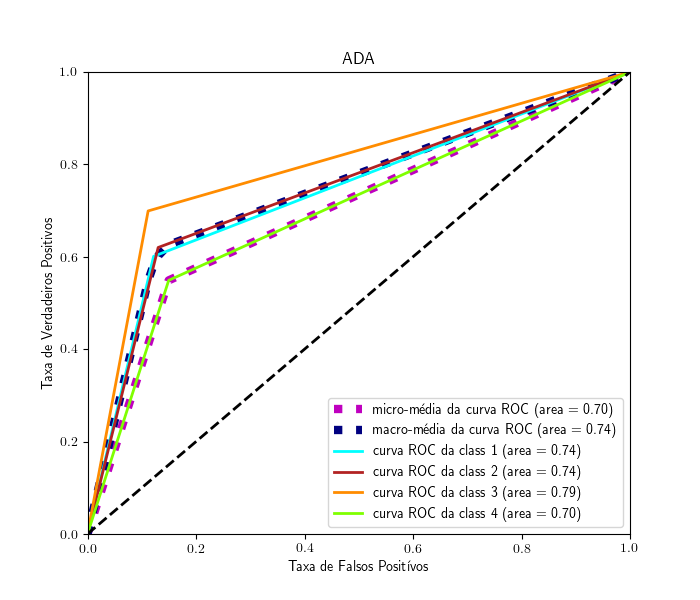

In [130]:
ROCCurve(bdt_real_y_pred, y_validate, 'ADA')

<IPython.core.display.Javascript object>


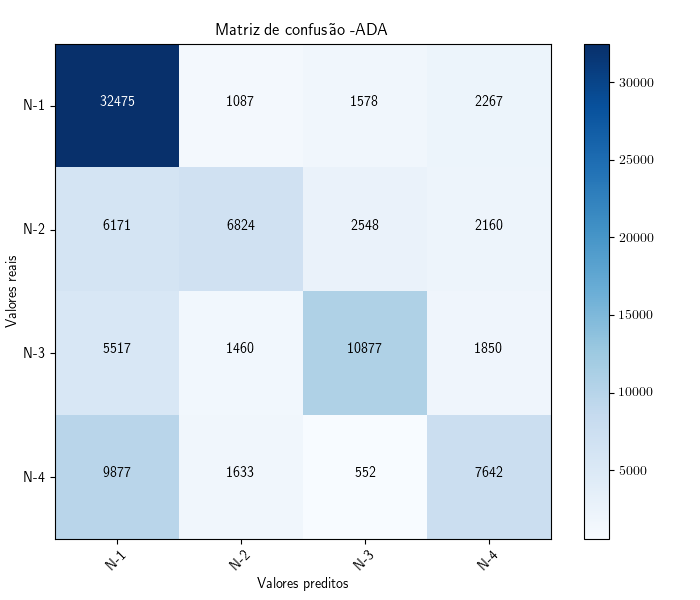

Matriz de confusão, sem normalização
[[32475  1087  1578  2267]
 [ 6171  6824  2548  2160]
 [ 5517  1460 10877  1850]
 [ 9877  1633   552  7642]]


<IPython.core.display.Javascript object>


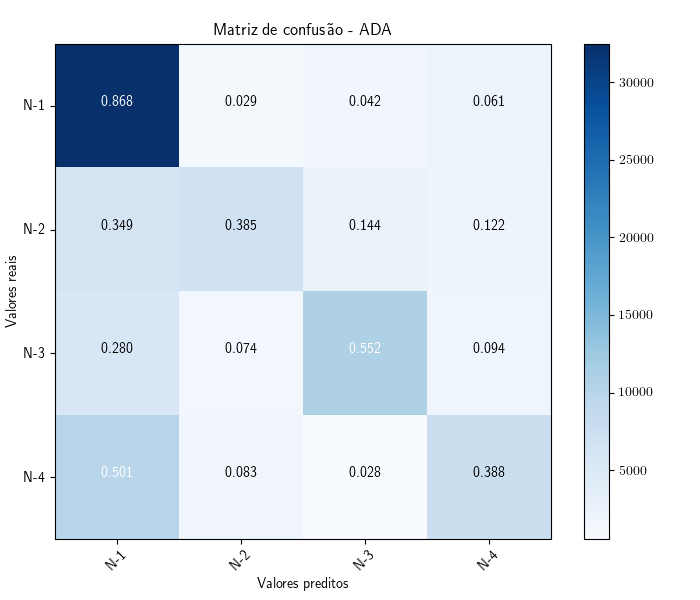

Matriz de confusão normalizada
[[0.87 0.03 0.04 0.06]
 [0.35 0.39 0.14 0.12]
 [0.28 0.07 0.55 0.09]
 [0.5  0.08 0.03 0.39]]

Métricas:
Sensitivity 61.73%
Specificity 87.16%
Precision 54.84%
Accuray 80.59%

Relatório:
             precision    recall  f1-score   support

        N-1       0.60      0.87      0.71     37407
        N-2       0.62      0.39      0.48     17703
        N-3       0.70      0.55      0.62     19704
        N-4       0.55      0.39      0.45     19704

avg / total       0.61      0.61      0.59     94518



In [134]:
Metrics(bdt_real_y_pred, y_validate, 'ADA')